Compare salinity from LSB model and moorings.
==

Includes SFEI moorings and NOAA tide gages.


In [1]:
from __future__ import print_function
import os
import matplotlib

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm, dates
import numpy as np

In [3]:
import xarray as xr
import pandas as pd 
import glob

In [4]:
from osgeo import osr

In [33]:
from stompy import utils
from stompy.grid import unstructured_grid
from stompy.model.delft import dfm_grid
%matplotlib notebook

In [20]:
ls "/hpcvol1/rusty/dfm/lsb_dfm/runs"

medium_winter2016_02/    short_summer2016_02/            short_summer2016_04/
short_10d_20170925_p16/  short_summer2016_02b/           short_winter2015_05/
short_10d_p16/           short_summer2016_02_highnotch/  short_winter2016_05/
short_summer2016_00/     short_summer2016_02_lownotch/
short_summer2016_01/     short_summer2016_03/


In [38]:
# Select run
try:
    his.close() # maybe avoid some unwanted caching behavior.
except NameError:
    pass

root='/hpcvol1/rusty/dfm/lsb_dfm/runs'

run_name="short_summer2016_02" # decent
# run_name="short_summer2016_02_lownotch" # either same or slightly better
# run_name="short_summer2016_02_highnotch" #  worse
#run_name="short_summer2016_03" # high friction, different, not really better.
#run_name="short_summer2016_04" # just longer than 02
# run_name="short_winter2015_05"
#fig_dir="fig-lsb_dfm-20180401_02"


fig_dir="fig-lsb_dfm-20180401_02"

# DFM's version of the run-name may be different if this run has been copied.
fns=glob.glob(os.path.join(root,run_name,"*.mdu"))
fns.sort()
dfm_run_name=os.path.basename(fns[0]).replace('.mdu','')

dfm_dir=os.path.join(root,run_name)
dfm_out_dir=os.path.join(dfm_dir,'DFM_OUTPUT_%s'%dfm_run_name)
fn_patt=os.path.join(dfm_out_dir,'%s_0000_*_000000_his.nc'%dfm_run_name)
his_fn=glob.glob(fn_patt)[0]
print("Opening his file ",his_fn)
his=xr.open_dataset(his_fn)

os.path.exists(fig_dir) or os.makedirs(fig_dir)
None

Opening his file  /hpcvol1/rusty/dfm/lsb_dfm/runs/short_summer2016_02/DFM_OUTPUT_short_summer2016_02/short_summer2016_02_0000_20160601_000000_his.nc


In [8]:
#sfei_csv_dir='../../../../../00_Master_Data_Repository/C2_Moored_Sensors/2_Results/EXO/data/L2/'
sfei_csv_dir="/opt/data/sfei/moored_sensors_csv/L2/"

class SFEI(object):
    def __init__(self,sfei_file):
        self.sfei_file=sfei_file
        self._df=None
    def df(self,station_ds):
        if self._df is None:
            self._df=pd.read_csv(os.path.join(sfei_csv_dir,self.sfei_file),
                                 parse_dates=['Datetime','dt'])
        # trim to period
        df2=self._df[ (self._df.Datetime.values>station_ds.time.values[0]) 
                    & (self._df.Datetime.values<station_ds.time.values[-1]) ]
        df2=df2.copy()
        # standardize names
        df2['time']=df2.Datetime
        df2['water_level']=df2['Depth_m']
        df2['salinity']=df2['S_PSU']
        return df2

sfei_sites=[ ('ALV',SFEI('ALV_all_data_L2.csv'),'Alviso Slough'),
             ('SFEI_Guadalupe',SFEI('GL_all_data_L2.csv'),"Guadalupe Slough"),
             ('SFEI_A8Notch',SFEI('POND_all_data_L2.csv'),'Pond A8 Feeder'),
             ('SFEI_Coyote',SFEI('COY_all_data_L2.csv'),'Coyote Creek'),
             ('SFEI_Mowry',SFEI('MOW_all_data_L2.csv'),'Mowry Slough'),
             ('SFEI_Newark',SFEI('NW_all_data_L2.csv'),'Newark Slough'),
             ('DB',SFEI('DMB_all_data_L2.csv'),'Dumbarton Bridge')
]

<IPython.core.display.Javascript object>


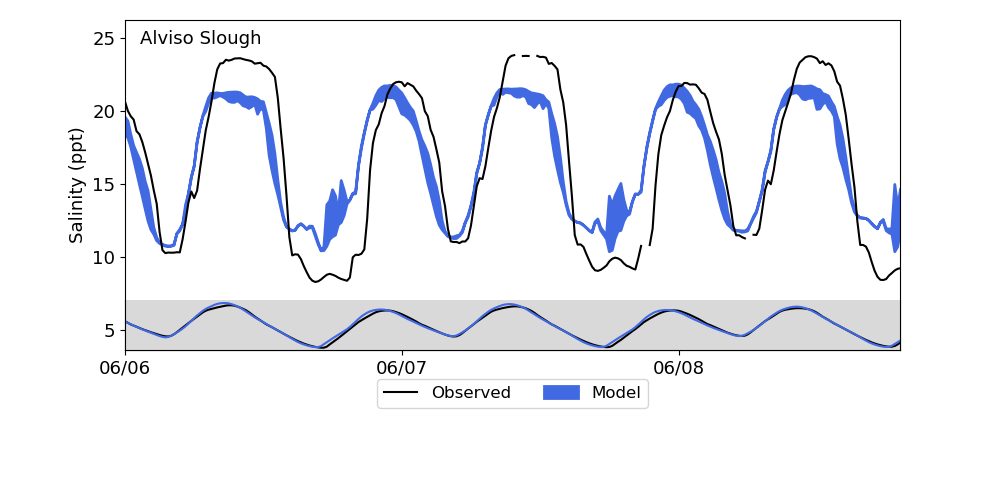

<IPython.core.display.Javascript object>


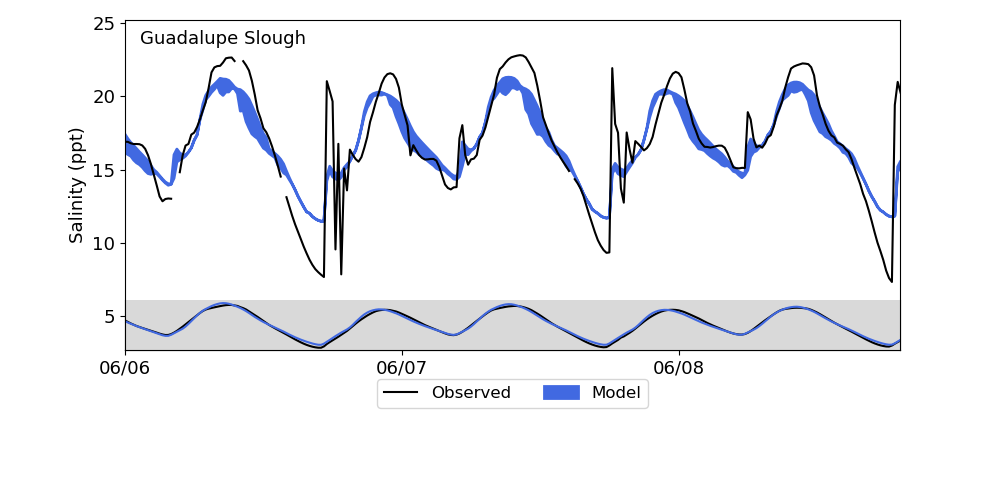

<IPython.core.display.Javascript object>


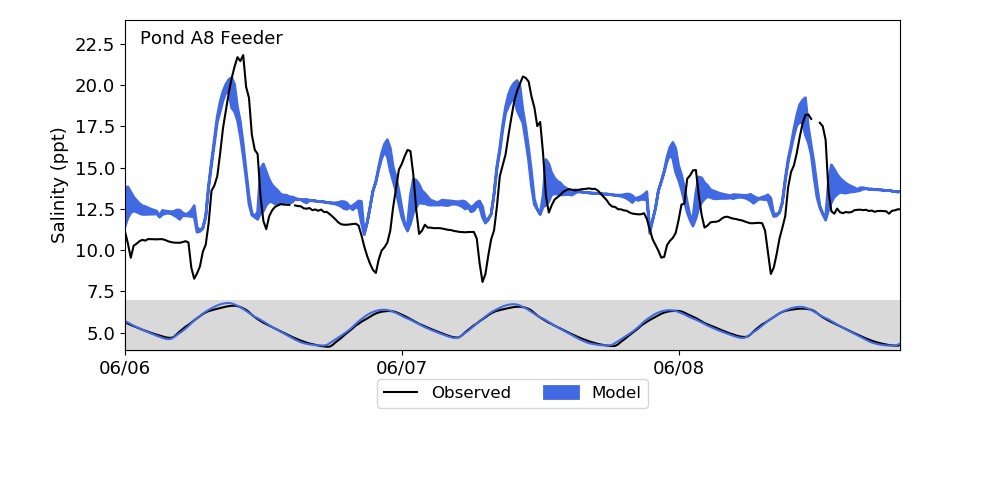

<IPython.core.display.Javascript object>


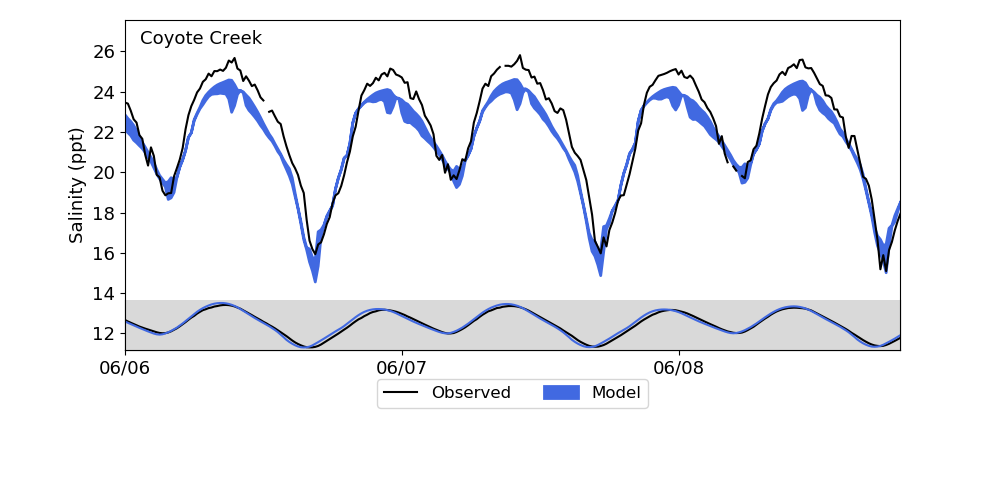

<IPython.core.display.Javascript object>


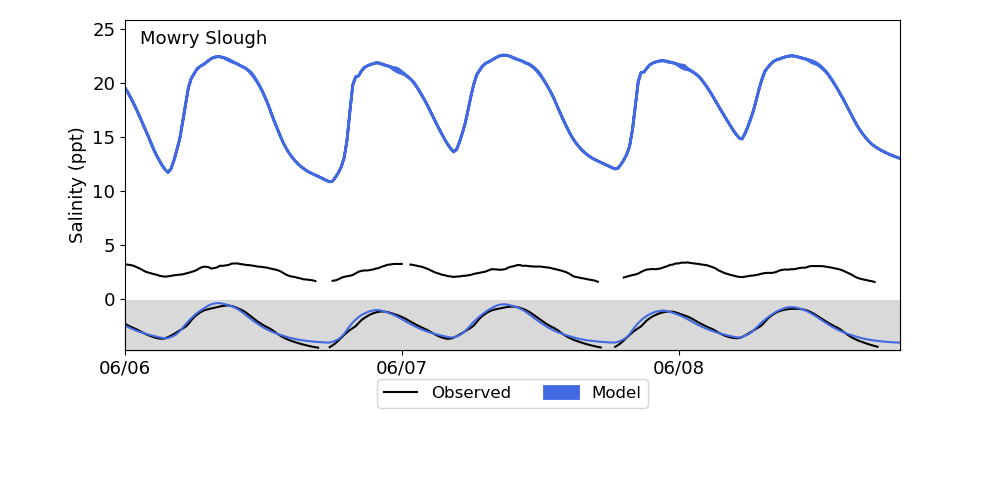

<IPython.core.display.Javascript object>


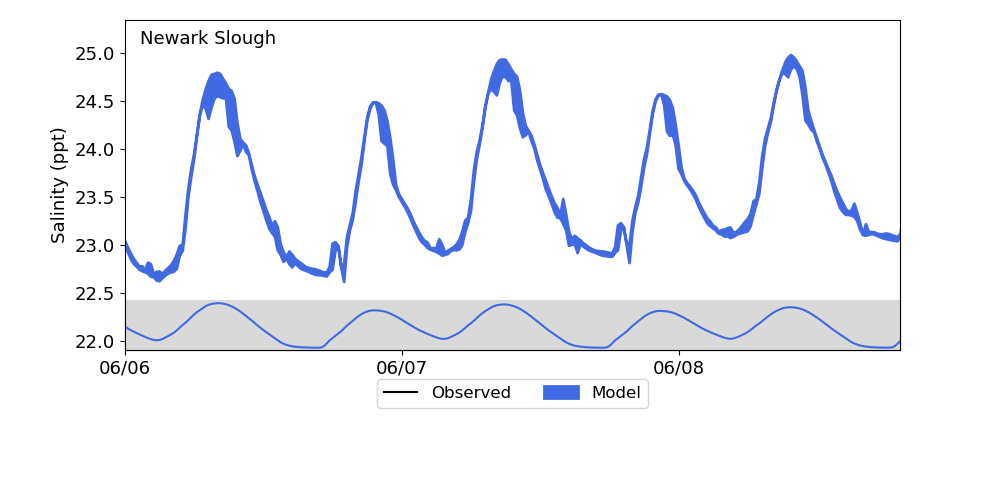

<IPython.core.display.Javascript object>


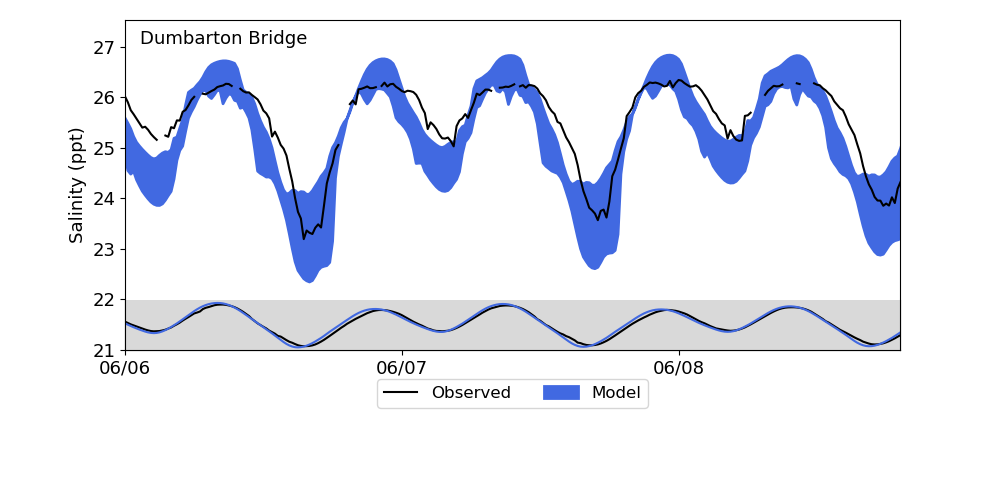

In [39]:
count=1

with_h=True
force=True
figsize=(10,5) # (6,3)
layered=False

obs_col='k'
mod_col='royalblue'

for dfm_name, observed, site_title in sfei_sites:
    try:
        b_dfm_name=dfm_name.encode()
    except AttributeError:
        b_dfm_name=dfm_name
    
    style=""
    if with_h:
        style+='_h'
    if layered:
        style+='_lay'
    if figsize==(10,5):
        style+='_med'
        
    img_fn=os.path.join(fig_dir,'salt_%s-%s-%sv01.png'%(run_name,dfm_name,style))
    if (not force) and os.path.exists(img_fn):
        print("Skipping %s"%dfm_name)
        continue

    # set this before calling df(), as it looks for station_ds inside
    # that method
    idx=np.nonzero( (his.station_name==b_dfm_name).values )[0][0]
    station_ds=his.isel(stations=idx)

    # these should come in as UTC
    mooring_df=observed.df(station_ds)

    #fig=plt.figure(count)
    #fig.clf()
    #fig.set_size_inches( figsize, forward=True )
    
    fig,ax=plt.subplots(figsize=figsize) # num=count)
    fig.subplots_adjust(bottom=0.3,top=0.96)
    
    if with_h:
        pos=ax.get_position()
        ax_h=fig.add_axes([pos.xmin,pos.ymin,pos.width,0.10])
    count+=1

    dnums=utils.to_dnum(station_ds.time.values)
            
    if layered: # all layers, color-coded
        for layi,laydim in enumerate(station_ds.laydim.values):
            Nlay=len(station_ds.laydim)
            col=cm.seismic( layi / float(Nlay-1) )
            if layi==0:
                label='Model bed'
            elif layi==Nlay-1:
                label='Model surface'
            else:
                label='__nolabel__'
            salinity=station_ds.salinity.isel(laydim=layi).values
            ax.plot(dnums,salinity,
                    color=col,label=label,lw=0.5)
    else: # top,bottom, shaded between
        ax.fill_between(dnums,
                        station_ds.salinity.min(dim='laydim').values,
                        station_ds.salinity.max(dim='laydim').values,
                        color=mod_col,label='Model',lw=2.0,zorder=-1)
                        
    if len(mooring_df.time.values):
        mooring_dnums=utils.to_dnum(mooring_df.time.values)
        ax.plot(mooring_dnums,
                mooring_df.salinity,
                color=obs_col,label='Observed',zorder=-1)

    if with_h:
        ax_h.plot(dnums, 
                  station_ds.waterlevel.values - station_ds.waterlevel.mean().values,
                  color=mod_col,label='Model %s $\eta$'%site_title)
        
        if len(mooring_df.time.values):
            ax_h.plot(mooring_dnums,
                      mooring_df.water_level - mooring_df.water_level.mean(),
                      color=obs_col,label='Observed',zorder=-1)
        
    ax.set_ylabel('Salinity (ppt)')
    #ax.legend(fontsize=9)
    if figsize==(10,5):
        leg_offset=[0.5,-0.2]
    else:
        leg_offset=[0.5,-0.4]
        
    ax.legend(fontsize=12,ncol=2,loc='lower center',bbox_to_anchor=leg_offset)

    s_max=max( station_ds.salinity.max(), mooring_df.salinity.max() )
    s_min=min( station_ds.salinity.min(), mooring_df.salinity.min() )
    s_pad=0.05*(s_max-s_min)
    
    # Pretty good period, though near the start of the run
    if 'summer' in run_name:
        x_range=[736121.0,736123.8]
        # x_range= (736119.0,736121.8)
        # Less interesting, and the time shift wrt observations is more prominent
        # x_range=( 736129.0,736131.8)
        # Maybe more interesting and further from IC?  More confusing, more drift, and
        # no alviso data.
        # x_range=(736134.0, 736136.8)
        # no data at 736139
        # x_range=(736128, 736131)
    else:  # winter run
        x_range=[735965,735971]

    if x_range[1]>dnums[-1]:
        delta=x_range[1] - x_range[0]
        x_range[1]=dnums[-1]
        x_range[0]=max(dnums[0],x_range[1]-delta)
        
    station_sel=(dnums>=x_range[0])&(dnums<=x_range[1])
    mooring_sel=(mooring_dnums>=x_range[0])&(mooring_dnums<=x_range[1])
    all_vals= np.concatenate( (station_ds.salinity.isel(time=station_sel).values.ravel(),
                               mooring_df.salinity.values[mooring_sel]) )
    s_max=np.nanmax(all_vals)
    s_min=np.nanmin(all_vals)
    s_pad=0.05*(s_max-s_min)
    ax.axis( xmin=x_range[0], xmax=x_range[1],ymin=s_min,ymax=s_max+3.1*s_pad)

    if with_h:
        ax_h.axis(xmin=ax.axis()[0],xmax=ax.axis()[1])
        ax_h.yaxis.set_visible(0)
        ax_h.xaxis.set_visible(0)
        plt.setp(ax_h.spines['top'],visible=0)
        #ax_h.patch.set_visible(0)
        ax_h.patch.set_zorder(-2)
        ax_h.patch.set_facecolor("0.85")
        ax.axis(ymin=s_min-6*s_pad)
    ax.text(0.02,0.97,site_title,fontsize=13,transform=ax.transAxes,
            va='top')

    if 0:
        fig.autofmt_xdate()
    else:
        ax.xaxis.set_major_locator( dates.DayLocator() )
        ax.xaxis.set_major_formatter( dates.DateFormatter("%m/%d") )

    plt.setp(ax.xaxis.get_ticklabels(),fontsize=13)
    plt.setp(ax.yaxis.get_ticklabels(),fontsize=13)
    plt.setp(ax.yaxis.get_label(),fontsize=13)

    #break

    # fig.savefig(img_fn,dpi=150)

Pond A8 Feeder has some reversed blips -

This is presumably from the pond getting initialized too salty, though it could also be upstream water that's too salty.


/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24,28,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/opt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24,28,49,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


[None, None]

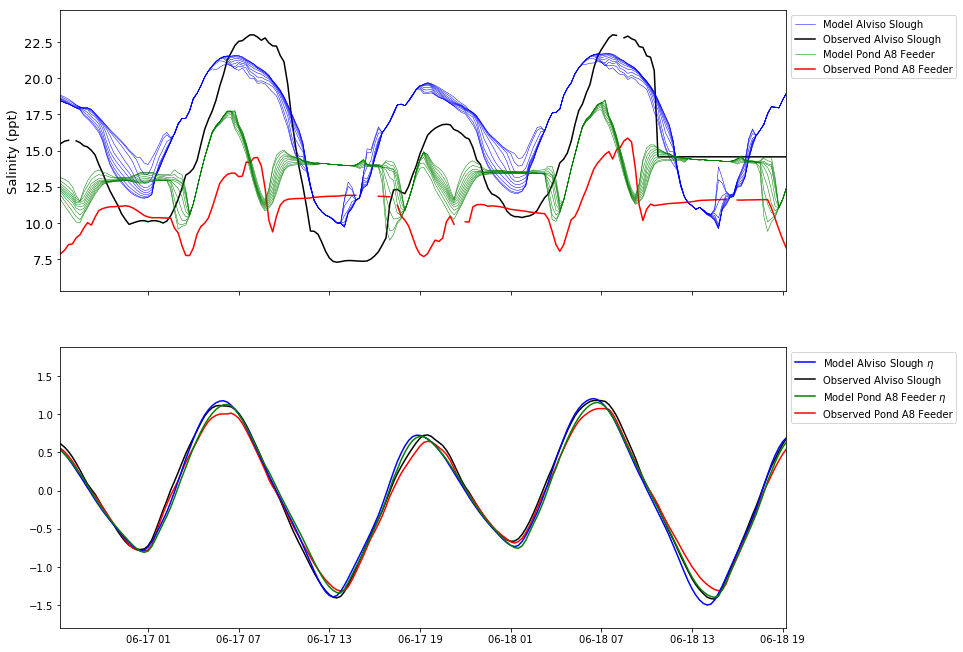

In [104]:
#dfm_name,observed,site_title = ('SFEI_A8Notch',SFEI('POND_all_data_L2.csv'),'Pond A8 Feeder')
fig,(ax,ax_h)=plt.subplots(2,1,figsize=(13,13),sharex=True)

count=0
for site_i,(dfm_name,observed,site_title) in enumerate(sfei_sites):
    if dfm_name not in ('SFEI_A8Notch','ALV'):
        continue
    count+=1
    b_dfm_name=dfm_name.encode()

    idx=np.nonzero( (his.station_name==b_dfm_name).values )[0][0]
    station_ds=his.isel(stations=idx)

    # these should come in as UTC
    mooring_df=observed.df()

    for layi,laydim in enumerate(station_ds.laydim.values):
        Nlay=len(station_ds.laydim)
        #col=cm.seismic( layi / float(Nlay-1) )
        col=['b','g'][count-1]
            
        if layi==0:
            label='Model %s'%site_title
        else:
            label='__nolabel__'
        obs_col=['k','r'][count-1]

        dnums=utils.to_dnum(station_ds.time.values)
        salinity=station_ds.salinity.isel(laydim=layi).values
        ax.plot(dnums,salinity,
                color=col,label=label,lw=0.5)
    ax_h.plot(dnums, 
              station_ds.waterlevel.values - station_ds.waterlevel.mean().values,
              color=col,label='Model %s $\eta$'%site_title)

    # Plot observations:
    if len(mooring_df.time.values):
        mooring_dnums=utils.to_dnum(mooring_df.time.values)
        ax.plot(mooring_dnums,
                mooring_df.salinity,
                color=obs_col,label='Observed %s'%site_title,zorder=-1)

        ax_h.plot(mooring_dnums,
                  mooring_df.water_level - mooring_df.water_level.mean(),
                  color=obs_col,label='Observed %s'%site_title,zorder=-1)

ax.set_ylabel('Salinity (ppt)')

ax.legend(fontsize=10,
          loc='upper left',
          bbox_to_anchor=[1.,1.0])
ax_h.legend(fontsize=10,
          loc='upper left',
          bbox_to_anchor=[1.,1.0])

fig.subplots_adjust(bottom=0.3,top=0.96)

s_max=max( station_ds.salinity.max(), mooring_df.salinity.max() )
s_min=min( station_ds.salinity.min(), mooring_df.salinity.min() )
s_pad=0.05*(s_max-s_min)

#ax.axis(xmin=736117.8,xmax=736119.8)
ax.axis(xmin=736131.8,xmax=736133.8)
    
# ax.xaxis.set_major_locator( dates.DayLocator() )
# ax.xaxis.set_major_formatter( dates.DateFormatter("%m/%d") )
ax.xaxis.axis_date()


plt.setp(ax.xaxis.get_ticklabels(),fontsize=13)
plt.setp(ax.yaxis.get_ticklabels(),fontsize=13)
plt.setp(ax.yaxis.get_label(),fontsize=13)


In [91]:
# Compare history files between two runs:

# Select run

try:
    his_a.close() # maybe avoid some unwanted caching behavior.
except NameError:
    pass
try:
    his_b.close()
except NameError:
    pass

def from_run_name(run_name):
    dfm_dir=os.path.join(root,run_name)
    dfm_out_dir=os.path.join(dfm_dir,'DFM_OUTPUT_%s'%run_name)
    fn_patt=os.path.join(dfm_out_dir,'%s_0000_*_000000_his.nc'%run_name)
    his_fn=glob.glob(fn_patt)[0]
    print("Opening his file ",his_fn)
    return xr.open_dataset(his_fn)

his_a=from_run_name("short_summer2016_02")
his_b=from_run_name("short_summer2016_03")
label_a='02'
label_b='03'

Opening his file  /hpcvol1/rusty/dfm/lsb_dfm/runs/short_summer2016_02/DFM_OUTPUT_short_summer2016_02/short_summer2016_02_0000_20160601_000000_his.nc
Opening his file  /hpcvol1/rusty/dfm/lsb_dfm/runs/short_summer2016_03/DFM_OUTPUT_short_summer2016_03/short_summer2016_03_0000_20160601_000000_his.nc


(736116.0, 736118.16666666663, 7.5845225811850536, 25.419242315507123)

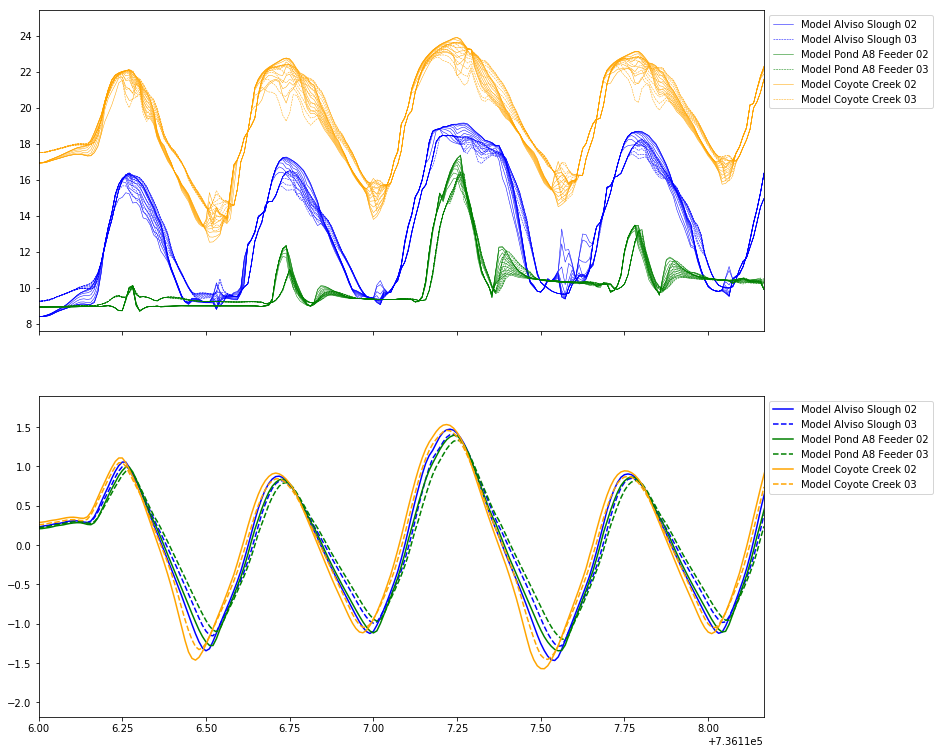

In [92]:
fig,(ax,ax_h)=plt.subplots(2,1,figsize=(13,13),sharex=True)

count=0

for site_i,(dfm_name,observed,site_title) in enumerate(sfei_sites):
    if dfm_name not in ('SFEI_A8Notch','ALV','SFEI_Coyote'):
        continue
    b_dfm_name=dfm_name.encode()
    count+=1
    col=['b','g','orange','r'][count-1]

    for h,run_label,ls in [(his_a,label_a,'-'),
                           (his_b,label_b,'--')]:

        idx=np.nonzero( (h.station_name==b_dfm_name).values )[0][0]
        station_ds=h.isel(stations=idx)
        
        for layi,laydim in enumerate(station_ds.laydim.values):
            Nlay=len(station_ds.laydim)

            if layi==0:
                label='Model %s %s'%(site_title,run_label)
            else:
                label='__nolabel__'

            dnums=utils.to_dnum(station_ds.time.values)
            salinity=station_ds.salinity.isel(laydim=layi).values
            ax.plot(dnums,salinity,
                    color=col,label=label,lw=0.5,ls=ls)
        ax_h.plot(dnums, 
                  station_ds.waterlevel.values - station_ds.waterlevel.mean().values,
                  color=col,label='Model %s %s'%(site_title,run_label),ls=ls)

ax.legend(fontsize=10,
          loc='upper left',
          bbox_to_anchor=[1.,1.0])
ax_h.legend(fontsize=10,
          loc='upper left',
          bbox_to_anchor=[1.,1.0])

ax.axis( xmin=utils.to_dnum(his_b.time.values[0]),
         xmax=utils.to_dnum(his_b.time.values[-1]))

In [159]:
24*np.median(np.diff(utils.to_dnum(his.time.values)))
10 * 24 * 4 

960

Pond A8 Feeder


<IPython.core.display.Javascript object>


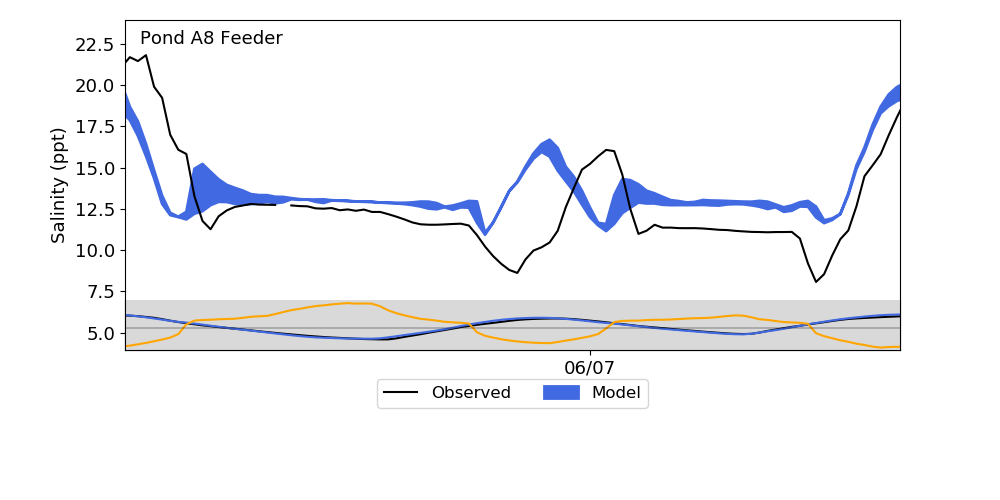

In [19]:
# How do the weird features in the notch line up with the local velocity?

count=1

with_h=True
with_u=True

force=True
figsize=(10,5) # (6,3)
layered=False

obs_col='k'
mod_col='royalblue'

for dfm_name, observed, site_title in sfei_sites:
    if site_title!='Pond A8 Feeder':
        continue

    print(site_title)
    try:
        b_dfm_name=dfm_name.encode()
    except AttributeError:
        b_dfm_name=dfm_name
    
    style=""
    if with_h:
        style+='_h'
    if layered:
        style+='_lay'
    if figsize==(10,5):
        style+='_med'
        
    img_fn=os.path.join(fig_dir,'salt_%s-%s-%sv01.png'%(run_name,dfm_name,style))
    if (not force) and os.path.exists(img_fn):
        print("Skipping %s"%dfm_name)
        continue

    # set this before calling df(), as it looks for station_ds inside
    # that method
    idx=np.nonzero( (his.station_name==b_dfm_name).values )[0][0]
    station_ds=his.isel(stations=idx)

    # these should come in as UTC
    mooring_df=observed.df(station_ds)

    #fig=plt.figure(count)
    #fig.clf()
    #fig.set_size_inches( figsize, forward=True )
    
    fig,ax=plt.subplots(figsize=figsize)
    fig.subplots_adjust(bottom=0.3,top=0.96)
    
    if with_h:
        pos=ax.get_position()
        ax_h=fig.add_axes([pos.xmin,pos.ymin,pos.width,0.10])
    count+=1

    dnums=utils.to_dnum(station_ds.time.values)
            
    if layered: # all layers, color-coded
        for layi,laydim in enumerate(station_ds.laydim.values):
            Nlay=len(station_ds.laydim)
            col=cm.seismic( layi / float(Nlay-1) )
            if layi==0:
                label='Model bed'
            elif layi==Nlay-1:
                label='Model surface'
            else:
                label='__nolabel__'
            salinity=station_ds.salinity.isel(laydim=layi).values
            ax.plot(dnums,salinity,
                    color=col,label=label,lw=0.5)
    else: # top,bottom, shaded between
        ax.fill_between(dnums,
                        station_ds.salinity.min(dim='laydim').values,
                        station_ds.salinity.max(dim='laydim').values,
                        color=mod_col,label='Model',lw=2.0,zorder=-1)
                        
    if len(mooring_df.time.values):
        mooring_dnums=utils.to_dnum(mooring_df.time.values)
        ax.plot(mooring_dnums,
                mooring_df.salinity,
                color=obs_col,label='Observed',zorder=-1)

    if with_h:
        ax_h.plot(dnums, 
                  station_ds.waterlevel.values - station_ds.waterlevel.mean().values,
                  color=mod_col,label='Model %s $\eta$'%site_title)
        
        if len(mooring_df.time.values):
            ax_h.plot(mooring_dnums,
                      mooring_df.water_level - mooring_df.water_level.mean(),
                      color=obs_col,label='Observed',zorder=-1)
        
        if with_u:
            u_vel=station_ds.x_velocity.mean(dim='laydim')
            ax_h.plot(dnums,5*u_vel.values,color='orange',label='U-velocity')
            
    ax.set_ylabel('Salinity (ppt)')
    #ax.legend(fontsize=9)
    if figsize==(10,5):
        leg_offset=[0.5,-0.2]
    else:
        leg_offset=[0.5,-0.4]
        
    ax.legend(fontsize=12,ncol=2,loc='lower center',bbox_to_anchor=leg_offset)

    s_max=max( station_ds.salinity.max(), mooring_df.salinity.max() )
    s_min=min( station_ds.salinity.min(), mooring_df.salinity.min() )
    s_pad=0.05*(s_max-s_min)
    
    # Pretty good period, though near the start of the run
    if 'summer' in run_name:
        x_range=(736121.4,736122.4)
        # x_range= (736119.0,736121.8)
        # Less interesting, and the time shift wrt observations is more prominent
        # x_range=( 736129.0,736131.8)
        # Maybe more interesting and further from IC?  More confusing, more drift, and
        # no alviso data.
        # x_range=(736134.0, 736136.8)
        # no data at 736139
        # x_range=(736128, 736131)
    else:  # winter run
        x_range=(735965,735971)

    station_sel=(dnums>=x_range[0])&(dnums<=x_range[1])
    mooring_sel=(mooring_dnums>=x_range[0])&(mooring_dnums<=x_range[1])
    all_vals= np.concatenate( (station_ds.salinity.isel(time=station_sel).values.ravel(),
                               mooring_df.salinity.values[mooring_sel]) )
    s_max=np.nanmax(all_vals)
    s_min=np.nanmin(all_vals)
    s_pad=0.05*(s_max-s_min)
    ax.axis( xmin=x_range[0], xmax=x_range[1],ymin=s_min,ymax=s_max+3.1*s_pad)

    if with_h:
        ax_h.axis(xmin=ax.axis()[0],xmax=ax.axis()[1])
        ax_h.yaxis.set_visible(0)
        ax_h.xaxis.set_visible(0)
        plt.setp(ax_h.spines['top'],visible=0)
        #ax_h.patch.set_visible(0)
        ax_h.patch.set_zorder(-2)
        ax_h.patch.set_facecolor("0.85")
        ax.axis(ymin=s_min-6*s_pad)
        ax_h.axhline(0.0,lw=0.3,color='k')
    ax.text(0.02,0.97,site_title,fontsize=13,transform=ax.transAxes,
            va='top')

    if 0:
        fig.autofmt_xdate()
    else:
        ax.xaxis.set_major_locator( dates.DayLocator() )
        ax.xaxis.set_major_formatter( dates.DateFormatter("%m/%d") )

    plt.setp(ax.xaxis.get_ticklabels(),fontsize=13)
    plt.setp(ax.yaxis.get_ticklabels(),fontsize=13)
    plt.setp(ax.yaxis.get_label(),fontsize=13)

    break

In [14]:
station_ds.x_velocity.mean(dim='laydim')

<xarray.DataArray 'x_velocity' (time: 1921)>
array([ 0.      ,  0.008652, -0.010385, ...,  0.041789,  0.070204,  0.076421])
Coordinates:
    station_x_coordinate  (time) float64 ...
    station_y_coordinate  (time) float64 ...
    station_name          |S12 b'SFEI_A8Notch'
  * time                  (time) datetime64[ns] 2016-06-01 ...